# Gramener Case Study

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 20

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#### External contants

In [3]:
loan_file_path="./loan/loan.csv"
data_dict_file_path = "./loan/Data_Dictionary.xlsx"

## Check Point 1:  Data Cleaning

### - Fetching ```loan``` data from given file

In [4]:
loan = pd.read_csv(loan_file_path, encoding="utf8")
loan.head()

C:\Users\achyut\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.000,36 months,10.65%,162.870,B,B2,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
1,1077430,1314167,2500,2500,2500.000,60 months,15.27%,59.830,C,C4,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
2,1077175,1313524,2400,2400,2400.000,36 months,15.96%,84.330,C,C5,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
3,1076863,1277178,10000,10000,10000.000,36 months,13.49%,339.310,C,C1,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
4,1075358,1311748,3000,3000,3000.000,60 months,12.69%,67.790,B,B5,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan


#### Finding number of rows and columns in the dataset

In [5]:
print('The loan dataset set has %d rows and %d columns' % (loan.shape[0], loan.shape[1]))

The loan dataset set has 39717 rows and 111 columns


#### Removing columns which have all values as ```NaN```

In [6]:
nan_count_df = loan.isnull().sum().to_frame('nan_count')
num_col_with_all_nan = nan_count_df.loc[nan_count_df['nan_count']  == loan.shape[0], :].shape[0]
print('Number of columns with all NaN values are %d.' % (num_col_with_all_nan))

Number of columns with all NaN values are 54.


In [7]:
# Removing columns which have all values as NaN
loans_frame = loan.dropna(axis=1, how="all")
print('The loan dataset set has now %d rows and %d columns' % (loans_frame.shape[0], loans_frame.shape[1]))

The loan dataset set has now 39717 rows and 57 columns


### - Fetching ```Data Dictionary```  from given file

In [8]:
data_dict = pd.read_excel(data_dict_file_path, sheet_name="LoanStats")
data_dict.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


#### Initial List of columns for consideration 

In [9]:
filtered_data_dict = data_dict.loc[data_dict['LoanStatNew'].isin(loans_frame.columns), :]

### Considering those loan entries which are  either `Fully Paid` or `Charged Off`  to discover any pattern in them
The reason for not selecting `Current` loans because we don't if they will be fully paid or default in future. After creating a model we can predict if `Current` loans will default or not.

In [10]:
loans_frame = loans_frame.loc[loans_frame['loan_status'].isin(['Fully Paid', 'Charged Off']), :]
loans_frame.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.000,36 months,10.65%,162.870,B,B2,...,NaN,May-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
1,1077430,1314167,2500,2500,2500.000,60 months,15.27%,59.830,C,C4,...,NaN,Sep-13,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
2,1077175,1313524,2400,2400,2400.000,36 months,15.96%,84.330,C,C5,...,NaN,May-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
3,1076863,1277178,10000,10000,10000.000,36 months,13.49%,339.310,C,C1,...,NaN,Apr-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000
5,1075269,1311441,5000,5000,5000.000,36 months,7.90%,156.460,A,A4,...,NaN,Jan-16,0.000,1,INDIVIDUAL,0,0.000,0,0.000,0.000


In [11]:
# Shape of the 'Charged Off' records i.e. number of records and columns
loans_frame.shape

(38577, 57)

In [12]:
clean_loan_df = loans_frame.isnull().sum().sort_index().to_frame('nan_count').reset_index()

In [13]:
# Creating a dataframe by merging the data dictional the clean_loan dataframe to get a better understanding
column_desc = pd.merge(filtered_data_dict, clean_loan_df, how="inner", left_on="LoanStatNew", right_on="index")
column_desc.loc[:,['LoanStatNew','Description','nan_count']]

,LoanStatNew,Description,nan_count
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.,0
1,addr_state,The state provided by the borrower in the loan application,0
2,annual_inc,The self-reported annual income provided by the borrower during registration.,0
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers,0
4,chargeoff_within_12_mths,Number of charge-offs within 12 months,56
5,collection_recovery_fee,post charge off collection fee,0
6,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections,56
7,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years,0
8,delinq_amnt,The past-due amount owed for the accounts on which the borrower is now delinquent.,0
9,desc,Loan description provided by the borrower,12526


In [14]:
column_desc.loc[column_desc['nan_count'] > 0,['LoanStatNew','Description','nan_count']]

,LoanStatNew,Description,nan_count
4,chargeoff_within_12_mths,Number of charge-offs within 12 months,56
6,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections,56
9,desc,Loan description provided by the borrower,12526
13,emp_title,The job title supplied by the Borrower when applying for the loan.*,2385
24,last_credit_pull_d,The most recent month LC pulled credit for this loan,2
26,last_pymnt_d,Last month payment was received,71
30,mths_since_last_delinq,The number of months since the borrower's last delinquency.,24905
31,mths_since_last_record,The number of months since the last public record.,35837
32,next_pymnt_d,Next scheduled payment date,38577
38,pub_rec_bankruptcies,Number of public record bankruptcies,697


##### Removing columns  
- ```mths_since_last_delinq```, ```mths_since_last_record```, ```next_pymnt_d``` as the contain more 50% values as NaN
- ```emp_title```, ```desc```, ```title```, ```url``` are irrelevant for EDA

In [15]:
#### Removing columns  mths_since_last_delinq, mths_since_last_record, next_pymnt_d, emp_title, desc
columns_to_remove = ['emp_title', 'desc', 'url', 'title']
columns_under_process = column_desc.loc[~column_desc['LoanStatNew'].isin(columns_to_remove), 'LoanStatNew'].values
loans_frame = loans_frame.loc[:,columns_under_process]

# Validate will take 50% percent as cutoff and will keep below that
max_allowed_nan = len(loans_frame)/2
print(max_allowed_nan)
loans_frame = loans_frame.loc[:,(nan_count_df['nan_count'] < max_allowed_nan)]
print(loans_frame.isnull().sum())

19288.5
acc_now_delinq                0  
addr_state                    0  
annual_inc                    0  
application_type              0  
chargeoff_within_12_mths      56 
collection_recovery_fee       0  
collections_12_mths_ex_med    56 
delinq_2yrs                   0  
delinq_amnt                   0  
dti                           0  
earliest_cr_line              0  
emp_length                    0  
funded_amnt                   0  
funded_amnt_inv               0  
grade                         0  
home_ownership                0  
id                            0  
initial_list_status           0  
inq_last_6mths                0  
installment                   0  
int_rate                      0  
issue_d                       0  
last_credit_pull_d            2  
last_pymnt_amnt               0  
last_pymnt_d                  71 
loan_amnt                     0  
loan_status                   0  
member_id                     0  
open_acc                      0  
out_pr

In [16]:
loans_frame.shape

(38577, 50)

In [17]:
print("Total number of unique member in the data set is %d" % loans_frame['member_id'].nunique())

Total number of unique member in the data set is 38577


In [18]:
pd.options.display.max_columns = 100 # To see all columns
loans_frame.describe()

,acc_now_delinq,annual_inc,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,funded_amnt,funded_amnt_inv,id,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,member_id,open_acc,out_prncp,out_prncp_inv,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,revol_bal,tax_liens,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
count,38577.000,38577.000,38521.000,38577.000,38521.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000,37880.000,38577.000,38577.000,38538.000,38577.000,38577.000,38577.000,38577.000,38577.000,38577.000
mean,0.000,68777.974,0.000,12.773,0.000,0.147,0.000,13.273,10784.059,10222.481,676378.707,0.872,322.466,2746.243,11047.025,842284.337,9.275,0.000,0.000,1.000,0.055,0.043,98.036,13289.490,0.000,22.053,11866.970,11271.196,2119.243,1.369,9648.323
std,0.000,64218.682,0.000,150.837,0.000,0.492,0.000,6.673,7090.306,7022.721,209263.898,1.072,208.639,4494.648,7348.442,264451.929,4.402,0.000,0.000,0.000,0.238,0.205,698.650,15866.492,0.000,11.426,8809.856,8700.846,2389.500,7.316,7009.381
min,0.000,4000.000,0.000,0.000,0.000,0.000,0.000,0.000,500.000,0.000,54734.000,0.000,15.690,0.000,500.000,70699.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,40000.000,0.000,0.000,0.000,0.000,0.000,8.130,5200.000,5000.000,512033.000,0.000,165.740,217.420,5300.000,661131.000,6.000,0.000,0.000,1.000,0.000,0.000,0.000,3650.000,0.000,13.000,5513.497,5019.590,643.990,0.000,4500.000
50%,0.000,58868.000,0.000,0.000,0.000,0.000,0.000,13.370,9550.000,8733.440,656423.000,1.000,277.860,568.260,9600.000,839292.000,9.000,0.000,0.000,1.000,0.000,0.000,0.000,8762.000,0.000,20.000,9674.048,9066.660,1300.450,0.000,8000.000
75%,0.000,82000.000,0.000,0.000,0.000,0.000,0.000,18.560,15000.000,14000.000,829146.000,1.000,425.550,3447.250,15000.000,1037336.000,12.000,0.000,0.000,1.000,0.000,0.000,0.000,16912.000,0.000,29.000,16136.952,15329.780,2671.980,0.000,13175.000
max,0.000,6000000.000,0.000,7002.190,0.000,11.000,0.000,29.990,35000.000,35000.000,1077501.000,8.000,1305.190,36115.200,35000.000,1314167.000,44.000,0.000,0.000,1.000,4.000,2.000,29623.350,149588.000,0.000,90.000,58563.680,58563.680,23563.680,180.200,35000.020


In [19]:
# Validate all values in column is same by checking unique values in clumn
uniques = loans_frame.apply(lambda x:x.nunique())
print(uniques)

acc_now_delinq                1    
addr_state                    50   
annual_inc                    5215 
application_type              1    
chargeoff_within_12_mths      1    
collection_recovery_fee       2616 
collections_12_mths_ex_med    1    
delinq_2yrs                   11   
delinq_amnt                   1    
dti                           2853 
earliest_cr_line              524  
emp_length                    12   
funded_amnt                   1019 
funded_amnt_inv               8050 
grade                         7    
home_ownership                5    
id                            38577
initial_list_status           1    
inq_last_6mths                9    
installment                   15022
int_rate                      370  
issue_d                       55   
last_credit_pull_d            106  
last_pymnt_amnt               34418
last_pymnt_d                  101  
loan_amnt                     870  
loan_status                   2    
member_id                   

In [20]:
# Remove columns where unique values are 1 as it illustrates that all values are same in column
loans_frame = loans_frame.drop(uniques[uniques <= 1].index, axis = 1)
print(loans_frame.shape)
loans_frame.head()

(38577, 39)


,addr_state,annual_inc,collection_recovery_fee,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,grade,home_ownership,id,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,member_id,open_acc,pub_rec,pub_rec_bankruptcies,purpose,recoveries,revol_bal,revol_util,sub_grade,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,verification_status,zip_code
0,AZ,24000.000,0.000,0,27.650,Jan-85,10+ years,5000,4975.000,B,RENT,1077501,1,162.870,10.65%,Dec-11,May-16,171.620,Jan-15,5000,Fully Paid,1296599,3,0,0.000,credit_card,0.000,13648,83.70%,B2,36 months,9,5863.155,5833.840,863.160,0.000,5000.000,Verified,860xx
1,GA,30000.000,1.110,0,1.000,Apr-99,< 1 year,2500,2500.000,C,RENT,1077430,5,59.830,15.27%,Dec-11,Sep-13,119.660,Apr-13,2500,Charged Off,1314167,3,0,0.000,car,117.080,1687,9.40%,C4,60 months,4,1008.710,1008.710,435.170,0.000,456.460,Source Verified,309xx
2,IL,12252.000,0.000,0,8.720,Nov-01,10+ years,2400,2400.000,C,RENT,1077175,2,84.330,15.96%,Dec-11,May-16,649.910,Jun-14,2400,Fully Paid,1313524,2,0,0.000,small_business,0.000,2956,98.50%,C5,36 months,10,3005.667,3005.670,605.670,0.000,2400.000,Not Verified,606xx
3,CA,49200.000,0.000,0,20.000,Feb-96,10+ years,10000,10000.000,C,RENT,1076863,1,339.310,13.49%,Dec-11,Apr-16,357.480,Jan-15,10000,Fully Paid,1277178,10,0,0.000,other,0.000,5598,21%,C1,36 months,37,12231.890,12231.890,2214.920,16.970,10000.000,Source Verified,917xx
5,AZ,36000.000,0.000,0,11.200,Nov-04,3 years,5000,5000.000,A,RENT,1075269,3,156.460,7.90%,Dec-11,Jan-16,161.030,Jan-15,5000,Fully Paid,1311441,9,0,0.000,wedding,0.000,7963,28.30%,A4,36 months,12,5632.210,5632.210,632.210,0.000,5000.000,Source Verified,852xx


In [21]:
column_desc.loc[~column_desc['LoanStatNew'].isin(columns_to_remove), ['LoanStatNew', 'Description']]

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,addr_state,The state provided by the borrower in the loan application
2,annual_inc,The self-reported annual income provided by the borrower during registration.
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,collection_recovery_fee,post charge off collection fee
6,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
7,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
8,delinq_amnt,The past-due amount owed for the accounts on which the borrower is now delinquent.
10,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."


### Check Point 2: Univariate Analysis

From the above results we can now chalk out catergorical columns in the ```loans_frame```
- ```unordered categorical variables``` 
==> addr_state, application_type, home_ownership, initial_list_status, purpose, pymnt_plan, sub_grade, verification_status, zip_code
- ```ordered categorical variables```
==> emp_length, grade, sub_grade, term

In [22]:
def category_univariate_analysis(column_name):
    df = loans_frame.groupby('loan_status')[column_name].value_counts(ascending=False)\
                            .unstack(level=0).reset_index()
    df['Charged Off'].fillna(value=0, inplace=True)
    df['Total'] = df['Charged Off'] + df['Fully Paid']
    df['Charged_Off_Percent'] = df['Charged Off'] * 100 /df['Total']
    df['Fully_Paid_Percent'] = df['Fully Paid'] * 100 /df['Total']
    return df.sort_values(by='Charged_Off_Percent', ascending=False)

In [23]:
def power_law_df(df, column_name):
    s1 = np.log(df['Charged Off'].rank(axis=0, ascending=False)).to_frame(name='Rank_Log')
    s2 = np.log(df['Charged Off']).to_frame(name='Count_Log')
    s3 = df[column_name].to_frame(name=column_name)

    power_law_1 = pd.concat([s1, s2, s3], axis=1)
    power_law_1['status'] = 'Charged Off'

    s1 = np.log(df['Fully Paid'].rank(axis=0, ascending=False)).to_frame(name='Rank_Log')
    s2 = np.log(df['Fully Paid']).to_frame(name='Count_Log')

    power_law_2 = pd.concat([s1, s2, s3], axis=1)
    power_law_2['status'] = 'Fully Paid'

    power_law = pd.concat([power_law_1, power_law_2], ignore_index=True)
    return power_law

In [24]:
loans_frame['verification_status'].value_counts(normalize=True)

Not Verified      0.433
Verified          0.316
Source Verified   0.251
Name: verification_status, dtype: float64

In [25]:
verification_status_analysis = category_univariate_analysis('verification_status')
verification_status_analysis

loan_status,verification_status,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
2,Verified,2051,10155,12206,16.803,83.197
1,Source Verified,1434,8243,9677,14.819,85.181
0,Not Verified,2142,14552,16694,12.831,87.169


In [26]:
df = power_law_df(verification_status_analysis, 'verification_status')
df.sort_values(by='Rank_Log')

,Rank_Log,Count_Log,verification_status,status
2,0.000,7.669,Not Verified,Charged Off
5,0.000,9.585,Not Verified,Fully Paid
0,0.693,7.626,Verified,Charged Off
3,0.693,9.226,Verified,Fully Paid
1,1.099,7.268,Source Verified,Charged Off
4,1.099,9.017,Source Verified,Fully Paid


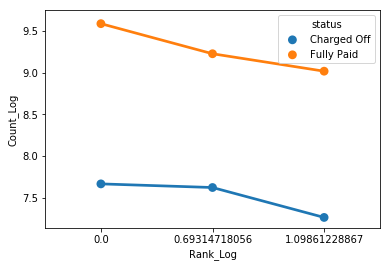

In [27]:
sns.pointplot(x="Rank_Log", y="Count_Log", hue="status", data=df.loc[:,['Rank_Log', 'Count_Log', 'status']])
plt.show()

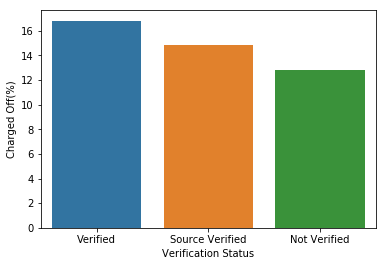

In [28]:
sns.barplot(x="verification_status", y="Charged_Off_Percent", data=verification_status_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Verification Status')
plt.show()

In [29]:
loans_frame['home_ownership'].value_counts(normalize=True)

RENT       0.479
MORTGAGE   0.441
OWN        0.077
OTHER      0.003
NONE       0.000
Name: home_ownership, dtype: float64

In [30]:
home_ownership_analysis = category_univariate_analysis('home_ownership')
home_ownership_analysis

loan_status,home_ownership,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
2,OTHER,18.000,80.000,98.000,18.367,81.633
4,RENT,2839.000,15641.000,18480.000,15.363,84.637
3,OWN,443.000,2532.000,2975.000,14.891,85.109
0,MORTGAGE,2327.000,14694.000,17021.000,13.671,86.329
1,NONE,0.000,3.000,3.000,0.000,100.000


In [31]:
df = power_law_df(home_ownership_analysis, 'home_ownership')
df.sort_values(by='Rank_Log')

C:\Users\achyut\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


,Rank_Log,Count_Log,home_ownership,status
1,0.000,7.951,RENT,Charged Off
6,0.000,9.658,RENT,Fully Paid
3,0.693,7.752,MORTGAGE,Charged Off
8,0.693,9.595,MORTGAGE,Fully Paid
2,1.099,6.094,OWN,Charged Off
7,1.099,7.837,OWN,Fully Paid
0,1.386,2.890,OTHER,Charged Off
5,1.386,4.382,OTHER,Fully Paid
4,1.609,-inf,NONE,Charged Off
9,1.609,1.099,NONE,Fully Paid


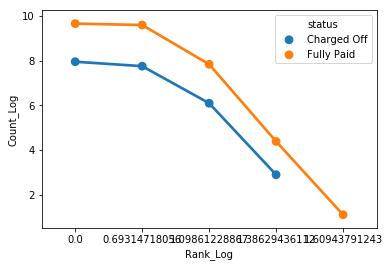

In [32]:
sns.pointplot(x="Rank_Log", y="Count_Log", hue="status", data=df.loc[:,['Rank_Log', 'Count_Log', 'status']])
plt.show()

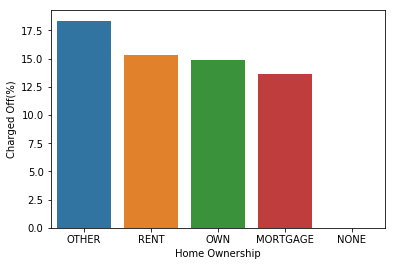

In [33]:
sns.barplot(x="home_ownership", y="Charged_Off_Percent", data=home_ownership_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Home Ownership')
plt.show()

In [34]:
loans_frame['purpose'].value_counts(normalize=True)

debt_consolidation   0.468
credit_card          0.130
other                0.100
home_improvement     0.075
major_purchase       0.056
small_business       0.045
car                  0.039
wedding              0.024
medical              0.018
moving               0.015
vacation             0.010
house                0.010
educational          0.008
renewable_energy     0.003
Name: purpose, dtype: float64

In [35]:
purpose_analysis = category_univariate_analysis('purpose')
purpose_analysis

loan_status,purpose,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
11,small_business,475,1279,1754,27.081,72.919
10,renewable_energy,19,83,102,18.627,81.373
3,educational,56,269,325,17.231,82.769
9,other,633,3232,3865,16.378,83.622
5,house,59,308,367,16.076,83.924
8,moving,92,484,576,15.972,84.028
7,medical,106,575,681,15.565,84.435
2,debt_consolidation,2767,15288,18055,15.325,84.675
12,vacation,53,322,375,14.133,85.867
4,home_improvement,347,2528,2875,12.070,87.930


In [36]:
df = power_law_df(purpose_analysis, 'purpose')
df.sort_values(by='Rank_Log')

,Rank_Log,Count_Log,purpose,status
21,0.000,9.635,debt_consolidation,Fully Paid
7,0.000,7.926,debt_consolidation,Charged Off
24,0.693,8.408,credit_card,Fully Paid
3,0.693,6.450,other,Charged Off
17,1.099,8.081,other,Fully Paid
10,1.099,6.295,credit_card,Charged Off
0,1.386,6.163,small_business,Charged Off
23,1.386,7.835,home_improvement,Fully Paid
9,1.609,5.849,home_improvement,Charged Off
27,1.609,7.564,major_purchase,Fully Paid


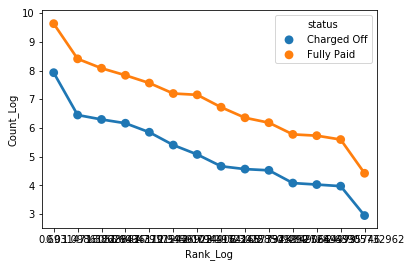

In [37]:
sns.pointplot(x="Rank_Log", y="Count_Log", hue="status", data=df.loc[:,['Rank_Log', 'Count_Log', 'status']])
plt.show()

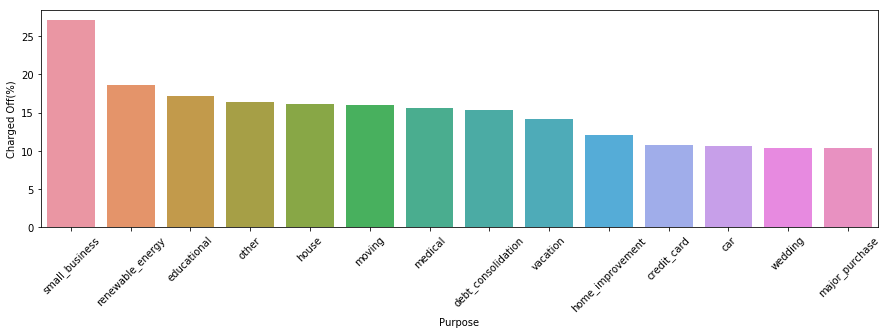

In [38]:
plt.figure(figsize=(15,4))
g = sns.barplot(x="purpose", y="Charged_Off_Percent", data=purpose_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Purpose')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

In [39]:
loans_frame['grade'].value_counts(normalize=True)

B   0.303
A   0.260
C   0.203
D   0.132
E   0.069
F   0.025
G   0.008
Name: grade, dtype: float64

In [40]:
grade_analysis = category_univariate_analysis('grade')
grade_analysis

loan_status,grade,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
6,G,101,198,299,33.779,66.221
5,F,319,657,976,32.684,67.316
4,E,715,1948,2663,26.849,73.151
3,D,1118,3967,5085,21.986,78.014
2,C,1347,6487,7834,17.194,82.806
1,B,1425,10250,11675,12.206,87.794
0,A,602,9443,10045,5.993,94.007


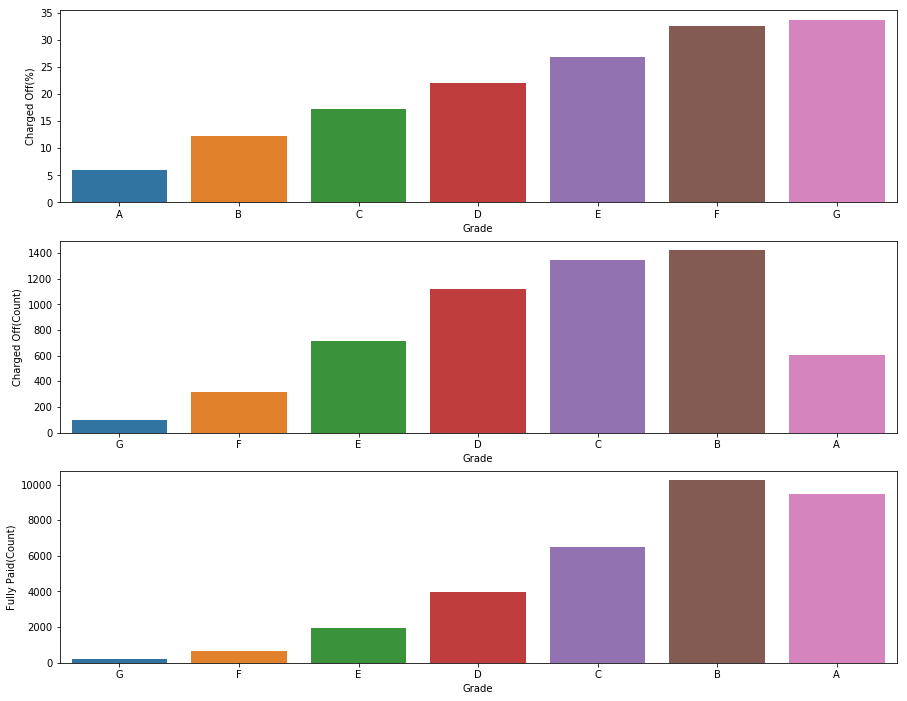

In [41]:
plt.figure(figsize=(15,12))
plt.subplot(3, 1, 1)
g = sns.barplot(x="grade", y="Charged_Off_Percent", data=grade_analysis.sort_values(by='grade'))\
    .set(ylabel='Charged Off(%)', xlabel='Grade')
    
plt.subplot(3, 1, 2)
sns.barplot(x="grade", y="Charged Off", data=grade_analysis)\
    .set(ylabel='Charged Off(Count)', xlabel='Grade')

plt.subplot(3, 1, 3)
sns.barplot(x="grade", y="Fully Paid", data=grade_analysis)\
    .set(ylabel='Fully Paid(Count)', xlabel='Grade')
plt.show()

In [42]:
category_univariate_analysis('sub_grade')

loan_status,sub_grade,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
29,F5,54,59,113,47.788,52.212
32,G3,19,26,45,42.222,57.778
31,G2,28,49,77,36.364,63.636
28,F4,53,98,151,35.099,64.901
34,G5,10,19,29,34.483,65.517
30,G1,31,63,94,32.979,67.021
26,F2,70,163,233,30.043,69.957
25,F1,91,214,305,29.836,70.164
23,E4,126,298,424,29.717,70.283
27,F3,51,123,174,29.310,70.690


In [43]:
loans_frame['emp_length'].value_counts(normalize=True)

10+ years   0.220
< 1 year    0.117
2 years     0.111
3 years     0.104
4 years     0.087
5 years     0.083
1 year      0.082
6 years     0.056
7 years     0.044
8 years     0.037
9 years     0.032
n/a         0.027
Name: emp_length, dtype: float64

In [44]:
emp_length_analysis = category_univariate_analysis('emp_length')
emp_length_analysis

loan_status,emp_length,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
11,n/a,228,805,1033,22.072,77.928
1,10+ years,1331,7157,8488,15.681,84.319
7,7 years,263,1448,1711,15.371,84.629
0,1 year,456,2713,3169,14.389,85.611
5,5 years,458,2736,3194,14.339,85.661
10,< 1 year,639,3869,4508,14.175,85.825
6,6 years,307,1861,2168,14.161,85.839
8,8 years,203,1232,1435,14.146,85.854
3,3 years,555,3457,4012,13.833,86.167
4,4 years,462,2880,3342,13.824,86.176


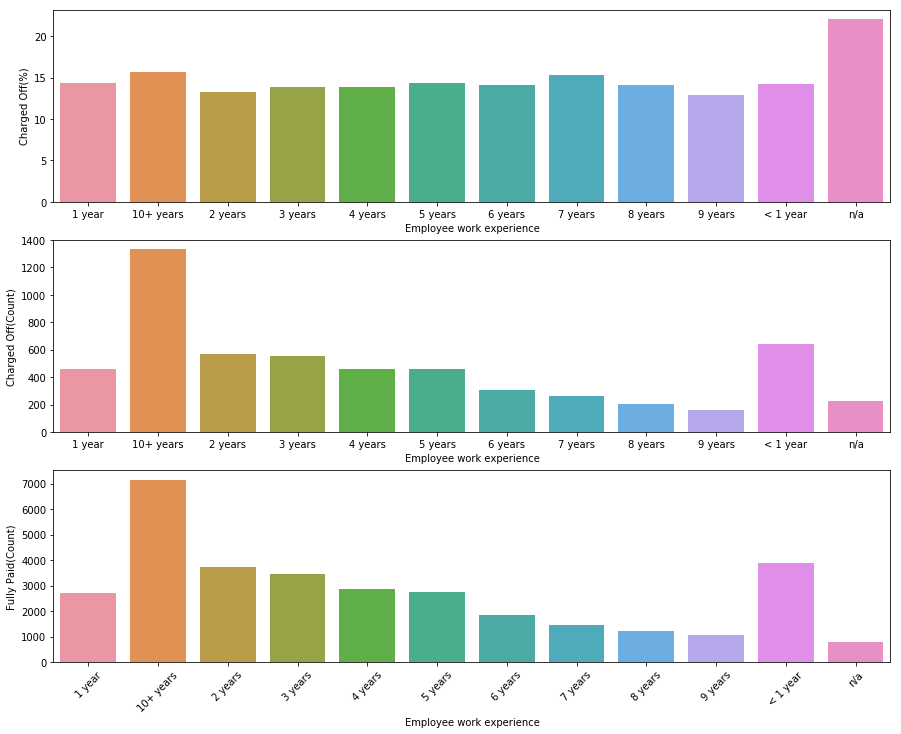

In [45]:
plt.figure(figsize=(15,12))
plt.subplot(3, 1, 1)
sns.barplot(x="emp_length", y="Charged_Off_Percent", data=emp_length_analysis.sort_values(by='emp_length'))\
    .set(ylabel='Charged Off(%)', xlabel='Employee work experience')
    
plt.subplot(3, 1, 2)
sns.barplot(x="emp_length", y="Charged Off", data=emp_length_analysis.sort_values(by='emp_length'))\
    .set(ylabel='Charged Off(Count)', xlabel='Employee work experience')

plt.subplot(3, 1, 3)
sns.barplot(x="emp_length", y="Fully Paid", data=emp_length_analysis.sort_values(by='emp_length'))\
    .set(ylabel='Fully Paid(Count)', xlabel='Employee work experience')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

In [46]:
loans_frame['term'].value_counts(normalize=True)

 36 months   0.754
 60 months   0.246
Name: term, dtype: float64

In [47]:
term_analysis = category_univariate_analysis('term')
term_analysis

loan_status,term,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
1,60 months,2400,7081,9481,25.314,74.686
0,36 months,3227,25869,29096,11.091,88.909


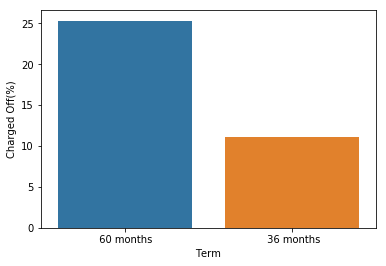

In [48]:
g = sns.barplot(x="term", y="Charged_Off_Percent", data=term_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Term')
plt.show()

In [49]:
loans_frame['addr_state'].value_counts(normalize=True)

CA   0.180
NY   0.096
FL   0.072
TX   0.069
NJ   0.046
IL   0.038
PA   0.038
VA   0.035
GA   0.035
MA   0.034
OH   0.031
MD   0.027
AZ   0.022
WA   0.021
CO   0.020
NC   0.019
CT   0.019
MI   0.018
MO   0.017
MN   0.016
NV   0.012
SC   0.012
WI   0.011
AL   0.011
OR   0.011
LA   0.011
KY   0.008
OK   0.007
KS   0.007
UT   0.007
AR   0.006
DC   0.005
RI   0.005
NM   0.005
WV   0.004
NH   0.004
HI   0.004
DE   0.003
MT   0.002
WY   0.002
AK   0.002
SD   0.002
VT   0.001
MS   0.000
TN   0.000
IN   0.000
ID   0.000
IA   0.000
NE   0.000
ME   0.000
Name: addr_state, dtype: float64

In [50]:
addr_state_analysis = category_univariate_analysis('addr_state')
addr_state_analysis

loan_status,addr_state,Charged Off,Fully Paid,Total,Charged_Off_Percent,Fully_Paid_Percent
28,NE,3.000,2.000,5.000,60.000,40.000
32,NV,108.000,371.000,479.000,22.547,77.453
40,SD,12.000,50.000,62.000,19.355,80.645
0,AK,15.000,63.000,78.000,19.231,80.769
9,FL,504.000,2277.000,2781.000,18.123,81.877
24,MO,114.000,556.000,670.000,17.015,82.985
11,HI,28.000,138.000,166.000,16.867,83.133
13,ID,1.000,5.000,6.000,16.667,83.333
31,NM,30.000,153.000,183.000,16.393,83.607
36,OR,71.000,364.000,435.000,16.322,83.678


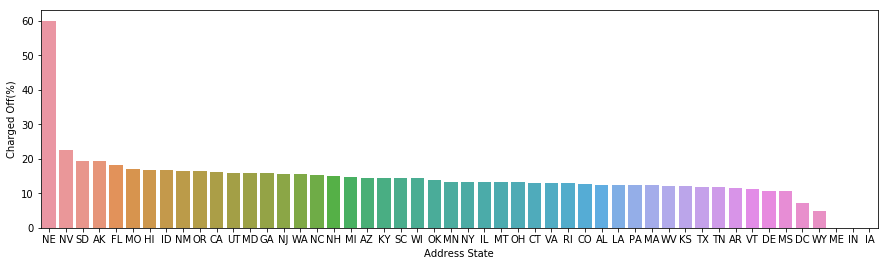

In [51]:
plt.figure(figsize=(15,4))
g = sns.barplot(x="addr_state", y="Charged_Off_Percent", data=addr_state_analysis)\
    .set(ylabel='Charged Off(%)', xlabel='Address State')
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=45)
plt.show()

#### Quatitative variable univariate analysis

In [52]:
loans_frame['revol_util'] = loans_frame['revol_util'].astype('str')
loans_frame['revol_util'] = loans_frame['revol_util'].map(lambda x : x.rstrip('%'))
loans_frame['revol_util'] = loans_frame['revol_util'].astype('float')
bins=[0,10,20,30,40,50,60,70,80,90,100]
pd.cut(loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','revol_util'], bins=bins).value_counts(normalize=True)

(70, 80]    0.127
(80, 90]    0.124
(60, 70]    0.121
(90, 100]   0.120
(50, 60]    0.115
(40, 50]    0.111
(30, 40]    0.092
(20, 30]    0.076
(10, 20]    0.061
(0, 10]     0.054
Name: revol_util, dtype: float64

In [53]:
loans_frame['revol_util'] = loans_frame['revol_util'].astype('str')
loans_frame['revol_util'] = loans_frame['revol_util'].map(lambda x : x.rstrip('%'))
loans_frame['revol_util'] = loans_frame['revol_util'].astype('float')
bins=[0,10,20,30,40,50,60,70,80,90,100]
pd.cut(loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','revol_util'], bins=bins).value_counts(normalize=True)

(40, 50]    0.113
(50, 60]    0.111
(30, 40]    0.109
(60, 70]    0.108
(20, 30]    0.102
(70, 80]    0.100
(0, 10]     0.099
(10, 20]    0.093
(80, 90]    0.090
(90, 100]   0.075
Name: revol_util, dtype: float64

In [54]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','revol_bal'].describe()

count   5627.000  
mean    13514.244 
std     15164.117 
min     0.000     
25%     3968.000  
50%     9211.000  
75%     17518.000 
max     148829.000
Name: revol_bal, dtype: float64

In [55]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','revol_bal'].describe()

count   32950.000 
mean    13251.108 
std     15983.260 
min     0.000     
25%     3603.000  
50%     8682.500  
75%     16804.750 
max     149588.000
Name: revol_bal, dtype: float64

In [56]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','dti'].describe()

count   5627.000
mean    14.001  
std     6.586   
min     0.000   
25%     9.050   
50%     14.290  
75%     19.290  
max     29.850  
Name: dti, dtype: float64

In [57]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','dti'].describe()

count   32950.000
mean    13.148   
std     6.680    
min     0.000    
25%     7.980    
50%     13.200   
75%     18.390   
max     29.990   
Name: dti, dtype: float64

In [58]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','open_acc'].describe()

count   5627.000
mean    9.178   
std     4.526   
min     2.000   
25%     6.000   
50%     8.000   
75%     12.000  
max     38.000  
Name: open_acc, dtype: float64

In [59]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','open_acc'].describe()

count   32950.000
mean    9.292    
std     4.380    
min     2.000    
25%     6.000    
50%     9.000    
75%     12.000   
max     44.000   
Name: open_acc, dtype: float64

In [60]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','total_acc'].describe()

count   5627.000
mean    21.428  
std     11.447  
min     2.000   
25%     13.000  
50%     20.000  
75%     28.000  
max     74.000  
Name: total_acc, dtype: float64

In [61]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','total_acc'].describe()

count   32950.000
mean    22.159   
std     11.419   
min     2.000    
25%     14.000   
50%     20.000   
75%     29.000   
max     90.000   
Name: total_acc, dtype: float64

In [62]:
def dateformat(earliest_cr_line_date):
    date_split = earliest_cr_line_date.split('-')
    if int(date_split[1]) > 18:
        date_split[1] = '19' +  date_split[1]
    else:
        date_split[1] = '20' +  date_split[1]
    return '-'.join(date_split)
loans_frame['earliest_cr_line_mod'] = loans_frame['earliest_cr_line'].apply(dateformat)

In [63]:
loans_frame['credit_history'] = round((pd.to_datetime(loans_frame['issue_d'], format='%b-%y') - \
                                pd.to_datetime(loans_frame['earliest_cr_line_mod'], format='%b-%Y')) / np.timedelta64(1, 'M'))
loans_frame['credit_history'].head()

0   323.000
1   152.000
2   121.000
3   190.000
5   85.000 
Name: credit_history, dtype: float64

In [64]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','credit_history'].describe()

count   5627.000
mean    161.552 
std     81.101  
min     36.000  
25%     108.000 
50%     147.000 
75%     199.000 
max     588.000 
Name: credit_history, dtype: float64

In [65]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','credit_history'].describe()

count   32950.000
mean    165.205  
std     82.110   
min     36.000   
25%     109.000  
50%     150.000  
75%     204.000  
max     785.000  
Name: credit_history, dtype: float64

In [66]:
loans_frame.loc[:,['annual_inc','installment','revol_bal']]
loans_frame['new_debt_annual_inc_ratio'] = (loans_frame['installment'] * 12 + loans_frame['revol_bal']) /\
                                            loans_frame['annual_inc']
loans_frame['new_debt_annual_inc_ratio'].head()

0   0.650
1   0.080
2   0.324
3   0.197
5   0.273
Name: new_debt_annual_inc_ratio, dtype: float64

In [67]:
loans_frame.loc[loans_frame['loan_status'] == 'Charged Off','new_debt_annual_inc_ratio'].describe()

count   5627.000
mean    0.298   
std     0.210   
min     0.002   
25%     0.145   
50%     0.256   
75%     0.401   
max     3.261   
Name: new_debt_annual_inc_ratio, dtype: float64

In [68]:
loans_frame.loc[loans_frame['loan_status'] == 'Fully Paid','new_debt_annual_inc_ratio'].describe()

count   32950.000
mean    0.263    
std     0.198    
min     0.001    
25%     0.120    
50%     0.215    
75%     0.355    
max     3.209    
Name: new_debt_annual_inc_ratio, dtype: float64

In [69]:
loans_frame.shape

(38577, 42)

## Bivariate Analysis
##### Let see co relation between columns with charged off and fully paid customers. 

In [72]:
loans_frame.head()

,addr_state,annual_inc,collection_recovery_fee,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,grade,home_ownership,id,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,member_id,open_acc,pub_rec,pub_rec_bankruptcies,purpose,recoveries,revol_bal,revol_util,sub_grade,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,verification_status,zip_code,earliest_cr_line_mod,credit_history,new_debt_annual_inc_ratio
0,AZ,24000.000,0.000,0,27.650,Jan-85,10+ years,5000,4975.000,B,RENT,1077501,1,162.870,10.65%,Dec-11,May-16,171.620,Jan-15,5000,Fully Paid,1296599,3,0,0.000,credit_card,0.000,13648,83.700,B2,36 months,9,5863.155,5833.840,863.160,0.000,5000.000,Verified,860xx,Jan-1985,323.000,0.650
1,GA,30000.000,1.110,0,1.000,Apr-99,< 1 year,2500,2500.000,C,RENT,1077430,5,59.830,15.27%,Dec-11,Sep-13,119.660,Apr-13,2500,Charged Off,1314167,3,0,0.000,car,117.080,1687,9.400,C4,60 months,4,1008.710,1008.710,435.170,0.000,456.460,Source Verified,309xx,Apr-1999,152.000,0.080
2,IL,12252.000,0.000,0,8.720,Nov-01,10+ years,2400,2400.000,C,RENT,1077175,2,84.330,15.96%,Dec-11,May-16,649.910,Jun-14,2400,Fully Paid,1313524,2,0,0.000,small_business,0.000,2956,98.500,C5,36 months,10,3005.667,3005.670,605.670,0.000,2400.000,Not Verified,606xx,Nov-2001,121.000,0.324
3,CA,49200.000,0.000,0,20.000,Feb-96,10+ years,10000,10000.000,C,RENT,1076863,1,339.310,13.49%,Dec-11,Apr-16,357.480,Jan-15,10000,Fully Paid,1277178,10,0,0.000,other,0.000,5598,21.000,C1,36 months,37,12231.890,12231.890,2214.920,16.970,10000.000,Source Verified,917xx,Feb-1996,190.000,0.197
5,AZ,36000.000,0.000,0,11.200,Nov-04,3 years,5000,5000.000,A,RENT,1075269,3,156.460,7.90%,Dec-11,Jan-16,161.030,Jan-15,5000,Fully Paid,1311441,9,0,0.000,wedding,0.000,7963,28.300,A4,36 months,12,5632.210,5632.210,632.210,0.000,5000.000,Source Verified,852xx,Nov-2004,85.000,0.273


In [73]:
# Remove % from int_rate for performing co relation
loans_frame['int_rate'] = loans_frame['int_rate'].apply(lambda x: float(x.split('%')[0]))
loans_frame.head()

,addr_state,annual_inc,collection_recovery_fee,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,grade,home_ownership,id,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,member_id,open_acc,pub_rec,pub_rec_bankruptcies,purpose,recoveries,revol_bal,revol_util,sub_grade,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,verification_status,zip_code,earliest_cr_line_mod,credit_history,new_debt_annual_inc_ratio
0,AZ,24000.000,0.000,0,27.650,Jan-85,10+ years,5000,4975.000,B,RENT,1077501,1,162.870,10.650,Dec-11,May-16,171.620,Jan-15,5000,Fully Paid,1296599,3,0,0.000,credit_card,0.000,13648,83.700,B2,36 months,9,5863.155,5833.840,863.160,0.000,5000.000,Verified,860xx,Jan-1985,323.000,0.650
1,GA,30000.000,1.110,0,1.000,Apr-99,< 1 year,2500,2500.000,C,RENT,1077430,5,59.830,15.270,Dec-11,Sep-13,119.660,Apr-13,2500,Charged Off,1314167,3,0,0.000,car,117.080,1687,9.400,C4,60 months,4,1008.710,1008.710,435.170,0.000,456.460,Source Verified,309xx,Apr-1999,152.000,0.080
2,IL,12252.000,0.000,0,8.720,Nov-01,10+ years,2400,2400.000,C,RENT,1077175,2,84.330,15.960,Dec-11,May-16,649.910,Jun-14,2400,Fully Paid,1313524,2,0,0.000,small_business,0.000,2956,98.500,C5,36 months,10,3005.667,3005.670,605.670,0.000,2400.000,Not Verified,606xx,Nov-2001,121.000,0.324
3,CA,49200.000,0.000,0,20.000,Feb-96,10+ years,10000,10000.000,C,RENT,1076863,1,339.310,13.490,Dec-11,Apr-16,357.480,Jan-15,10000,Fully Paid,1277178,10,0,0.000,other,0.000,5598,21.000,C1,36 months,37,12231.890,12231.890,2214.920,16.970,10000.000,Source Verified,917xx,Feb-1996,190.000,0.197
5,AZ,36000.000,0.000,0,11.200,Nov-04,3 years,5000,5000.000,A,RENT,1075269,3,156.460,7.900,Dec-11,Jan-16,161.030,Jan-15,5000,Fully Paid,1311441,9,0,0.000,wedding,0.000,7963,28.300,A4,36 months,12,5632.210,5632.210,632.210,0.000,5000.000,Source Verified,852xx,Nov-2004,85.000,0.273


In [74]:
# Function to drive a column named charged_off with 1 stating as customer charged off and 0 stating as customer not charged off
def addChargedOff(row):
    if(row['loan_status'] == 'Charged Off'):
        val = 1
    else :
        val = 0
    return val

# Function to drive a column named fully_paid with 1 stating as customer fully paid loan and 0 stating as customer not fully paid
def addFullyPaid(row):
    if(row['loan_status'] == 'Fully Paid'):
        val = 1
    else :
        val = 0
    return val
        
    

In [75]:
# Adding columns with the name of charged_off and fully_paid
loans_frame_without_current = loans_frame.loc[loans_frame['loan_status'] != 'Current']
loans_frame_without_current['charged_off'] = loans_frame_without_current.apply(addChargedOff,axis = 1)
loans_frame_without_current['fully_paid'] = loans_frame_without_current.apply(addFullyPaid, axis = 1)
loans_frame_without_current.head()

,addr_state,annual_inc,collection_recovery_fee,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,grade,home_ownership,id,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,member_id,open_acc,pub_rec,pub_rec_bankruptcies,purpose,recoveries,revol_bal,revol_util,sub_grade,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,verification_status,zip_code,earliest_cr_line_mod,credit_history,new_debt_annual_inc_ratio,charged_off,fully_paid
0,AZ,24000.000,0.000,0,27.650,Jan-85,10+ years,5000,4975.000,B,RENT,1077501,1,162.870,10.650,Dec-11,May-16,171.620,Jan-15,5000,Fully Paid,1296599,3,0,0.000,credit_card,0.000,13648,83.700,B2,36 months,9,5863.155,5833.840,863.160,0.000,5000.000,Verified,860xx,Jan-1985,323.000,0.650,0,1
1,GA,30000.000,1.110,0,1.000,Apr-99,< 1 year,2500,2500.000,C,RENT,1077430,5,59.830,15.270,Dec-11,Sep-13,119.660,Apr-13,2500,Charged Off,1314167,3,0,0.000,car,117.080,1687,9.400,C4,60 months,4,1008.710,1008.710,435.170,0.000,456.460,Source Verified,309xx,Apr-1999,152.000,0.080,1,0
2,IL,12252.000,0.000,0,8.720,Nov-01,10+ years,2400,2400.000,C,RENT,1077175,2,84.330,15.960,Dec-11,May-16,649.910,Jun-14,2400,Fully Paid,1313524,2,0,0.000,small_business,0.000,2956,98.500,C5,36 months,10,3005.667,3005.670,605.670,0.000,2400.000,Not Verified,606xx,Nov-2001,121.000,0.324,0,1
3,CA,49200.000,0.000,0,20.000,Feb-96,10+ years,10000,10000.000,C,RENT,1076863,1,339.310,13.490,Dec-11,Apr-16,357.480,Jan-15,10000,Fully Paid,1277178,10,0,0.000,other,0.000,5598,21.000,C1,36 months,37,12231.890,12231.890,2214.920,16.970,10000.000,Source Verified,917xx,Feb-1996,190.000,0.197,0,1
5,AZ,36000.000,0.000,0,11.200,Nov-04,3 years,5000,5000.000,A,RENT,1075269,3,156.460,7.900,Dec-11,Jan-16,161.030,Jan-15,5000,Fully Paid,1311441,9,0,0.000,wedding,0.000,7963,28.300,A4,36 months,12,5632.210,5632.210,632.210,0.000,5000.000,Source Verified,852xx,Nov-2004,85.000,0.273,0,1


In [76]:
# Driving corelation of charged_off and fully_paid with other columns.
corr = loans_frame_without_current.corr()
corr

,annual_inc,collection_recovery_fee,delinq_2yrs,dti,funded_amnt,funded_amnt_inv,id,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,member_id,open_acc,pub_rec,pub_rec_bankruptcies,recoveries,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,credit_history,new_debt_annual_inc_ratio,charged_off,fully_paid
annual_inc,1.000,0.016,0.022,-0.122,0.265,0.252,0.006,0.035,0.268,0.049,0.143,0.269,0.006,0.157,-0.018,-0.016,0.022,0.277,0.017,0.235,0.256,0.245,0.185,0.007,0.257,0.181,-0.098,-0.041,0.041
collection_recovery_fee,0.016,1.000,0.014,0.012,0.079,0.064,-0.011,0.012,0.078,0.070,-0.043,0.077,-0.013,0.007,-0.006,-0.005,0.797,0.023,0.027,0.011,0.028,0.019,0.042,0.094,-0.058,0.015,0.023,0.205,-0.205
delinq_2yrs,0.022,0.014,1.000,-0.033,-0.032,-0.038,-0.008,0.009,-0.020,0.158,-0.013,-0.032,-0.008,0.012,0.008,0.003,0.012,-0.054,-0.043,0.067,-0.023,-0.030,0.024,0.029,-0.038,0.065,-0.097,0.020,-0.020
dti,-0.122,0.012,-0.033,1.000,0.062,0.071,0.092,0.002,0.052,0.111,0.009,0.062,0.093,0.288,-0.005,0.006,0.026,0.228,0.279,0.229,0.059,0.066,0.103,-0.011,0.037,0.051,0.366,0.045,-0.045
funded_amnt,0.265,0.079,-0.032,0.062,1.000,0.956,0.131,0.013,0.958,0.305,0.478,0.982,0.130,0.176,-0.051,-0.037,0.143,0.307,0.067,0.251,0.899,0.865,0.737,0.049,0.864,0.193,0.248,0.056,-0.056
funded_amnt_inv,0.252,0.064,-0.038,0.071,0.956,1.000,0.232,-0.003,0.905,0.297,0.469,0.938,0.241,0.163,-0.051,-0.041,0.131,0.286,0.072,0.243,0.875,0.909,0.727,0.029,0.839,0.195,0.229,0.038,-0.038
id,0.006,-0.011,-0.008,0.092,0.131,0.232,1.000,-0.041,0.076,0.054,0.142,0.121,0.994,0.016,-0.018,-0.008,0.039,0.001,0.091,0.040,0.110,0.195,0.123,-0.056,0.093,0.065,0.007,0.042,-0.042
inq_last_6mths,0.035,0.012,0.009,0.002,0.013,-0.003,-0.041,1.000,0.011,0.133,0.028,0.013,-0.046,0.093,0.024,0.016,0.019,-0.021,-0.070,0.114,-0.008,-0.019,0.027,0.031,-0.021,0.001,-0.049,0.072,-0.072
installment,0.268,0.078,-0.020,0.052,0.958,0.905,0.076,0.011,1.000,0.277,0.414,0.932,0.071,0.173,-0.046,-0.033,0.121,0.310,0.093,0.230,0.858,0.818,0.643,0.058,0.848,0.168,0.255,0.027,-0.027
int_rate,0.049,0.070,0.158,0.111,0.305,0.297,0.054,0.133,0.277,1.000,0.174,0.301,0.051,0.006,0.099,0.083,0.129,0.094,0.467,-0.047,0.291,0.285,0.521,0.094,0.175,-0.122,0.085,0.211,-0.211


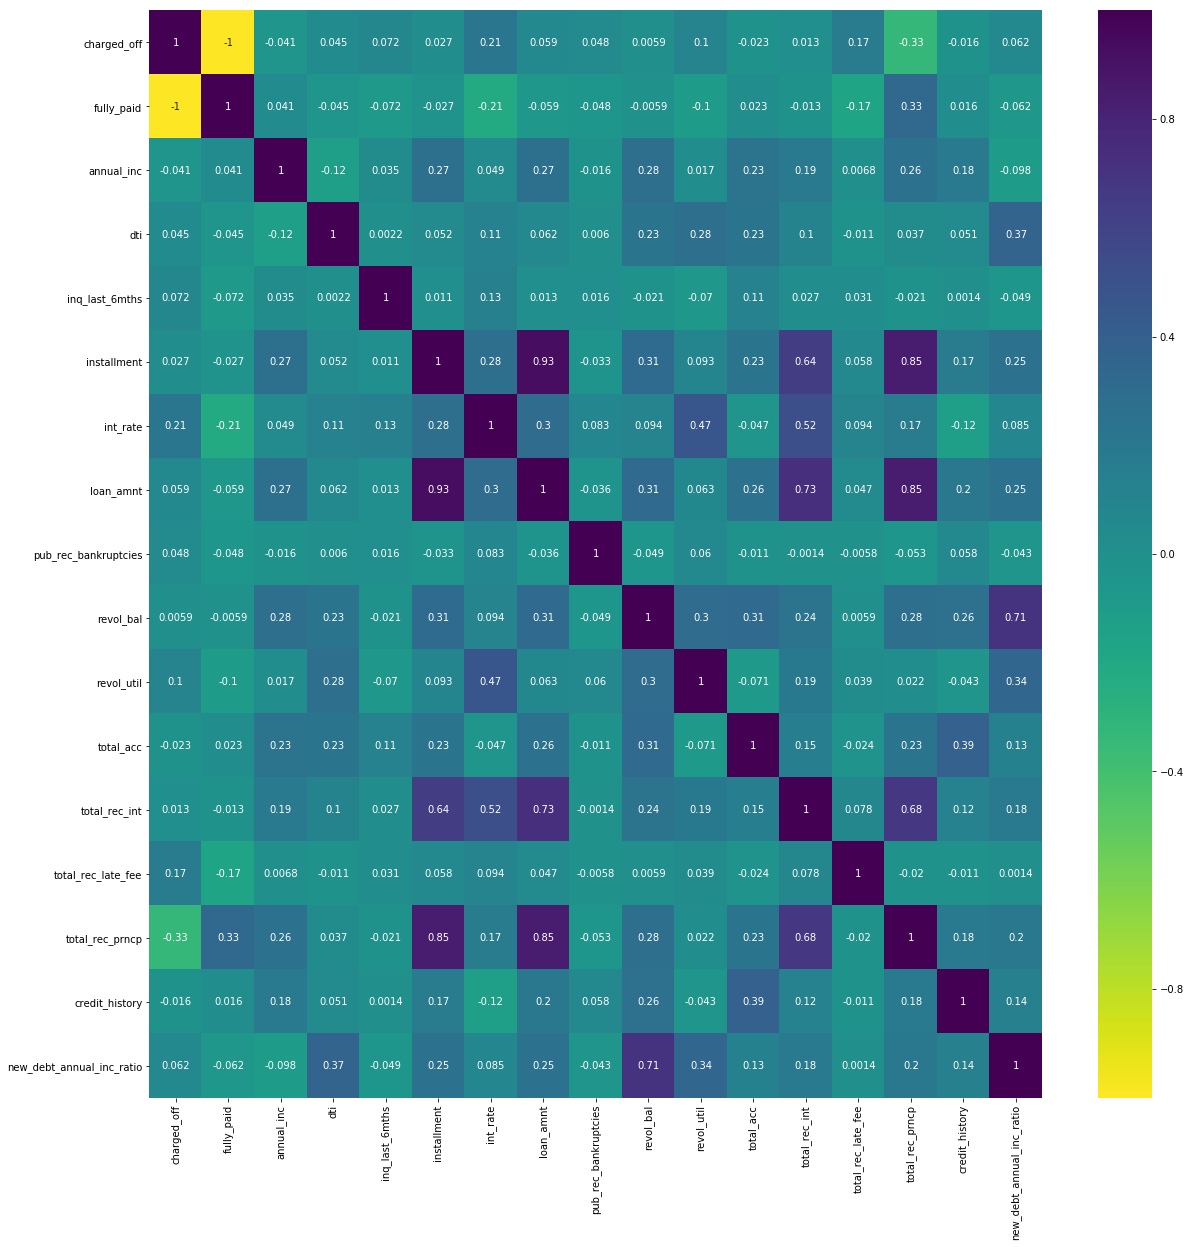

In [77]:
# Drawing heatmap to see pattern of corelation effecting loan getting default or fully paid
loans_frame_without_current = loans_frame_without_current[['charged_off','fully_paid','annual_inc','dti','inq_last_6mths','installment','int_rate','loan_amnt','pub_rec_bankruptcies','revol_bal','revol_util','total_acc','total_rec_int','total_rec_late_fee','total_rec_prncp','credit_history','new_debt_annual_inc_ratio']].copy()
plt.figure(figsize = (20,20))
sns.heatmap(loans_frame_without_current.corr(),annot=True,cmap='viridis_r')
plt.show()

## Conclusion:
Above trend shows co relation inwhich negative means decrease in attribute value increase the probability of the event and positve means increase in attribute value increase the probability of the event.

###### Below are reasons for probability of loan getting default / charged off
###### Low Annual Income
###### High DTI
###### High installments
###### High interest rate
###### High Loan amount 
###### High frequency of recieving of late fees
###### Less availbility of credit history


These above variables most probably influences loan success / unsuccess.
